# Intro
Goal: Use IBM PAIRS data to generate a fire risk model on large timescales. The code for accessing and downloading the PAIRS data is provided in a seperate file. Here we demonstrate the rudimentary training of a shallow CNN-LSTM network.

# Setup


Check what GPU we have. We executed this via Google Colab, so a Tesla T4 was used in the training.

In [3]:
# install the PAIRS Python client library
# NOTE: For the import to work in the following cells, the Google Colab runtime needs to be restarted. Not sure why... 
!pip install --user git+https://github.com/ibm/ibmpairs


  Cloning https://github.com/ibm/ibmpairs to /tmp/pip-req-build-trfra0u6
  Running command git clone -q https://github.com/ibm/ibmpairs /tmp/pip-req-build-trfra0u6
     |████████████████████████████████| 133kB 3.5MB/s 
  Created wheel for ibmpairs: filename=ibmpairs-0.1.0-py2.py3-none-any.whl size=23885 sha256=3738f215925ddbd4c34a35cbb81c06adeb7f85dff20e5921ea1a8ab595440090
  Stored in directory: /tmp/pip-ephem-wheel-cache-9oo5duf5/wheels/db/db/0b/b1029c1988e87728866bab6aee440be874fa434a97f942f32f
Successfully built ibmpairs


In [4]:
!nvidia-smi

Sun Feb  9 09:13:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import files
import os
import pandas as pd

Using TensorFlow backend.


In [5]:
!pip install ipywidgets

In [6]:
!pip install matplotlib

In [7]:
!pip install GeoPandas

     |████████████████████████████████| 921kB 3.4MB/s 
     |████████████████████████████████| 11.8MB 52.0MB/s 
     |████████████████████████████████| 10.1MB 48.0MB/s 


# Dataset parsing
As detailed in the other submitted code file, datasets were downloaded via the PAIRS API and saved as csv files.

In [0]:
# these datasets are precomputed and saved as csvs --> quicker
burns = []
veg = []
for f in sorted(os.listdir('./drive/My Drive/climate_hack')):
  if f.startswith('central'):
    f = './drive/My Drive/climate_hack/' + f
    if 'burn' in f:
      burns.append(np.array(pd.read_csv(f, header=None)))
    else:
      veg.append(np.array(pd.read_csv(f, header=None)))
input_array = np.array(list(zip(veg, burns)))

# Dataset visualisation

## An example of a vegetation input image...

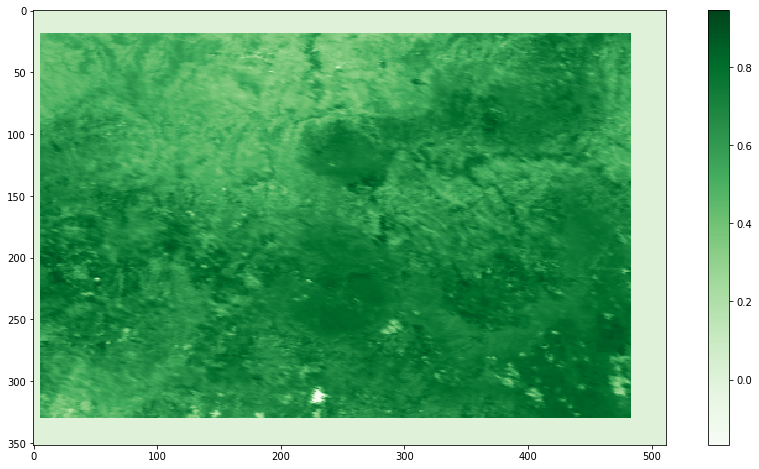

In [312]:
plt.figure(figsize = (15, 8))
plt.imshow(input_array[0][0], cmap = 'Greens')
plt.title('')
plt.colorbar()
plt.show()

## ... and of historical burns data

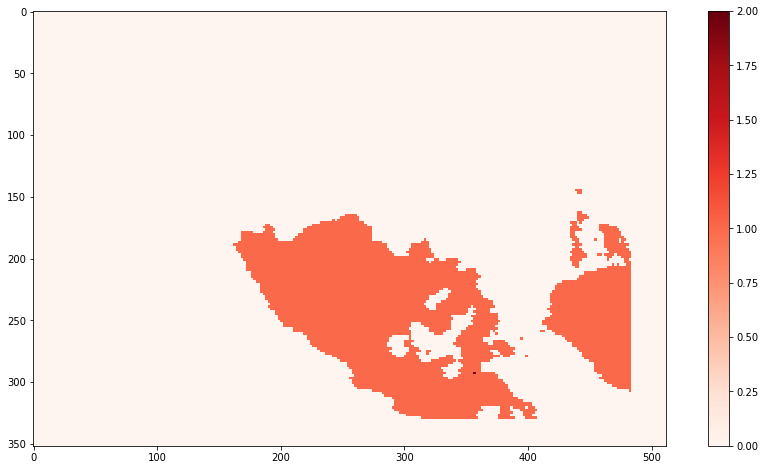

In [313]:
plt.figure(figsize = (15, 8))
# plt.imshow(np.where(pairs_query.data[Key] == NO_DATA_VALUE, np.nan, pairs_query.data[Key]), cmap = 'Reds')
plt.imshow(input_array[5][1], cmap = 'Reds')
plt.title('')
plt.colorbar()
plt.show()

# ML

In [0]:
import keras
from keras.layers import LSTM, Dropout, Conv2D, Dense, BatchNormalization, Flatten, Softmax, Conv3D, LSTM, TimeDistributed
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras import losses
from keras.optimizers import Adam

## Generate inputs and labels
Each input image is fragmented into overlapping segments at each timepoint. The input data has two channels for each of these 20x20 sub-images:
- Vegetation at timepoint t
- Aggregated burn history between timepoint t-1 and t

The images are labelled with a boolean indicating whether there will be a burn in the 20x20 area before timepoint t+1.

In [0]:
def get_input_lstm(in_array, sidelen, step):
    sub_arrs = []
    for x in range(0, in_array.shape[2] - sidelen, step):
        for y in range(0, in_array.shape[3] - sidelen, step):
            sub_arr_burns = np.expand_dims(in_array[:-1, 1, x:x+sidelen, y:y+sidelen], axis=-1)
            sub_arr_veg = np.expand_dims(in_array[1:, 0, x:x+sidelen, y:y+sidelen], axis=-1)
            sub_arr_comp = np.concatenate([sub_arr_veg, sub_arr_burns], axis=-1)
            sub_arrs.append(sub_arr_comp)
    return np.array(sub_arrs)

def get_labels_lstm(in_array, sidelen, step):
  labels = []
  for x in range(0, in_array.shape[2] - sidelen, step):
        for y in range(0, in_array.shape[3] - sidelen, step):
           sub_arr_burns = in_array[1:, 1, x:x+sidelen, y:y+sidelen]
           burn_sums = sub_arr_burns.sum(axis=(1, 2))
           burn_sums[burn_sums != 0] = 1
           labels.append(burn_sums)
  return np.array(labels)
  
          
input_dataset = get_input_lstm(input_array, sidelen=20, step=5)
input_labels = get_labels_lstm(input_array, sidelen=20, step=5)

## LSTM
LSTMs are able to learn from long time-dependancies. This does not matter much for the use case here (where only about 15 time steps can be considered), but this will be relevant in future extensions when the model would include more finegrained data inputs, e.g. monthly/daily temperature maxima. 

The architecture shown here was chosen for simplicity and training speed. We want to stress that this is a very simple proof of principle for pipelining PAIRS geospatial data into LSTM models. Any actually deployed model would be trained on several orders of magnitude more data (and data sources) and involve a more sophisticated architecture.

In [286]:
opt = Adam(lr=0.0001)

model_lstm = keras.Sequential()

model_lstm.add(TimeDistributed(
    Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu'),
    input_shape=(None, 20, 20, 2)))
model_lstm.add(TimeDistributed(
    Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')))
model_lstm.add(TimeDistributed(
    Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')))
model_lstm.add(TimeDistributed(
    Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')))

model_lstm.add(TimeDistributed(Flatten()))

model_lstm.add(LSTM(50, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [281]:
model_lstm.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_86 (TimeDis (None, None, 20, 20, 40)  760       
_________________________________________________________________
time_distributed_87 (TimeDis (None, None, 20, 20, 40)  14440     
_________________________________________________________________
time_distributed_88 (TimeDis (None, None, 20, 20, 40)  14440     
_________________________________________________________________
time_distributed_89 (TimeDis (None, None, 20, 20, 40)  14440     
_________________________________________________________________
time_distributed_90 (TimeDis (None, None, 16000)       0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                3210200   
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

There were 2 major burns in the dataset presented here (2009 and 2013). The test dataset ends at the 2013 burn, the train dataset at the 2009 one --> the test set can be used to check if the next burn risk is extrapolated correctly.

In [0]:
input_dataset_test = input_dataset[:,:10,:,:,:]
input_labels_test = input_labels[:, 9]

In [0]:
input_dataset_train = input_dataset[:,:5,:,:,:]
input_labels_train = input_labels[:, 4]

In [300]:
model_lstm.fit(x=input_dataset_train, y=input_labels_train, batch_size=32, epochs=1, verbose=1, validation_split=0.0)#, class_weight=weight_dict, shuffle=True)

Epoch 1/1
6633/6633 [==============================] - 1s 225us/step
[0.25503072300045104, 0.8808985376149555]
['loss', 'acc']


Get some quality metrics for the classifier:

In [301]:
from sklearn.metrics import roc_curve
y_pred = model_lstm.predict(input_dataset_test)
fpr, tpr, thresholds = roc_curve(input_labels_test, y_pred)
from sklearn.metrics import auc
auc = auc(fpr, tpr)

(6633, 1)


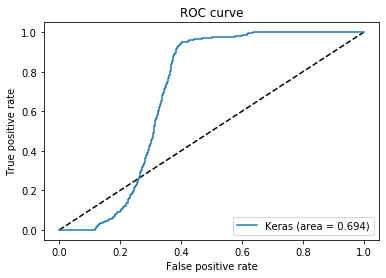

In [302]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Risk map generation
From the LSTM output, we generate an aggregate map of predicted fire outbreaks, where the value at each point within an 20x20 input grid is increased by the output scalar for that grid.

In [0]:
stitching = np.zeros(input_array.shape[2:4])
count = 0
for x in range(0, input_array.shape[2] - 20, 5):
    for y in range(0, input_array.shape[3] - 20, 5):
        stitching[x:x+20, y:y+20] += y_pred[count]
        count += 1

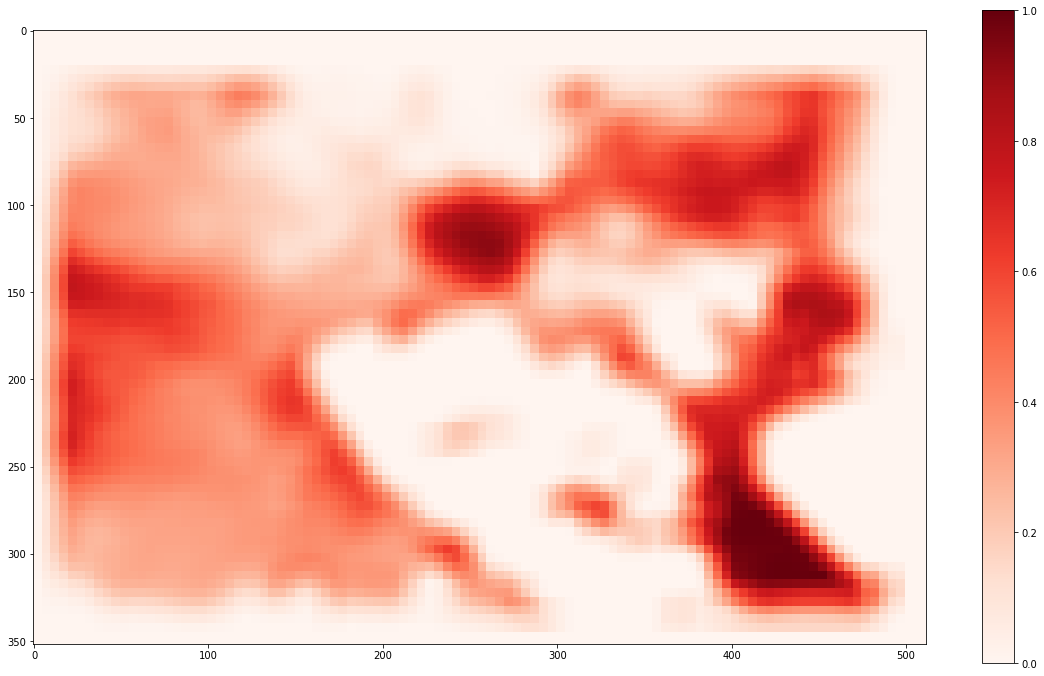

In [306]:
stitching = stitching/np.max(stitching)
plt.figure(figsize = (20, 12))
plt.imshow(stitching, cmap = 'Reds')
plt.title('')
plt.colorbar()
plt.show()